# 🔍 LangChain RAG Pipeline Tutorial Summary

This tutorial demonstrates how to build a Retrieval-Augmented Generation (RAG) pipeline using LangChain and OpenAI models, enhanced with LangGraph for structured agent workflows.

---

## 🧱 Key Components

- **Environment Setup**
  - Loads API keys securely using `dotenv`
  - Initializes OpenAI API for chat and embedding models

- **Chat Model**
  - Uses `ChatOpenAI` to handle simple user queries

- **Web Document Loading**
  - Fetches content from web sources via `WebBaseLoader`
  - Allows inspection of metadata and previewing document content

- **Text Splitting**
  - Breaks long documents into smaller, overlapping chunks using `RecursiveCharacterTextSplitter`

- **Embedding & Vector Store**
  - Embeds chunks using `OpenAIEmbeddings`
  - Stores vectors in a `Chroma` database for similarity search

- **Retriever**
  - Converts the vector store into a retriever interface
  - Enables semantic similarity-based document retrieval

- **Retriever Tool for LangGraph**
  - Wraps the retriever as a `retriever_tool` with a descriptive interface
  - Registers it as a `ToolNode` for use within LangGraph workflows

---

## 🔧 LangGraph Agent Workflow

The intelligent agent is built using LangGraph, consisting of modular nodes and conditional transitions to support decision-making and dynamic query handling.

### 🧩 Core Nodes

- **LLM Decision Maker**
  - Evaluates initial user input
  - Decides whether to respond directly or use a tool (retriever)

- **Vector Retriever**
  - Retrieves relevant documents from the vector store

- **Grading Node**
  - Evaluates whether retrieved content is relevant to the user’s query
  - Routes flow to either the output generator or query rewriter

- **Output Generator**
  - Uses RAG-style prompts to generate a detailed final answer

- **Query Rewriter**
  - Reformulates vague or off-target questions and sends them back to the decision node

### 🔄 Flow Logic

1. The process begins at the `LLM Decision Maker`
2. If a tool is needed, it transitions to `Vector Retriever`
3. The `grade_documents` function determines:
   - ✅ If relevant → move to `Output Generator` → then END
   - ❌ If not relevant → move to `Query Rewriter` → loops back to `LLM Decision Maker`

---

This architecture provides a flexible and intelligent QA pipeline, leveraging both LLM capabilities and retriever-based context augmentation with built-in reasoning and recovery loops.


In [11]:
# 📦 1. Import required libraries
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode

# 🔐 2. Load environment variables from .env (for your API key)
load_dotenv()

# 🔑 3. Set OpenAI API Key for LangChain usage
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# 🤖 4. Initialize the ChatOpenAI model (default is gpt-3.5 or gpt-4 depending on your config)
llm = ChatOpenAI()

# 💬 5. Send a test message to verify the model is working
response = llm.invoke("Hello, how are you my friend?")
print(response.content)  # Should print an AI-generated greeting

# 🧠 6. Initialize the embedding model (used for turning text into vectors)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# 🌐 7. Load a blog post webpage using LangChain's WebBaseLoader
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
web_loader = WebBaseLoader(url)
data = web_loader.load()  # Loads the page into a document object

# 🔍 8. Access and inspect the first document
doc = data[0]
print("Metadata:", doc.metadata)  # Shows the metadata like title, source, etc.
print("Description Length:", len(doc.metadata.get("description", "")))
print("Description:", doc.metadata.get("description"))
print("Page Content (first 500 chars):", doc.page_content[:500])

# 🌐 9. Load multiple webpages (for multi-doc RAG pipeline)
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
# Load and flatten all document lists into one list
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# ✂️ 10. Split documents into smaller chunks for embedding
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,  # each chunk has about 100 tokens
    chunk_overlap=25  # 25 tokens overlap between chunks
)
doc_splits = text_splitter.split_documents(docs_list)

# 🔎 11. Re-initialize embedding model (optional repeat)
embeddings = OpenAIEmbeddings()

# 🗂️ 12. Create a vector store using Chroma and store document chunks
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",  # name of your collection
    embedding=embeddings
)

# 🔍 13. Convert vectorstore to retriever (can now search it)
retriever = vectorstore.as_retriever()

# 💡 14. Query the retriever to get relevant chunks
response = retriever.invoke("what is agent and prompt?")
print(response)  # Should return most relevant text snippets

# 🛠️ 15. Create a retriever tool that can be used with LangGraph agents
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retriever_blog_post",
    description=(
        "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, "
        "and adversarial attacks on LLMs. You are a specialized assistant. Use the 'retriever_tool' **only** "
        "when the query explicitly relates to LangChain blog data. For all other queries, respond directly "
        "without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response."
    )
)

# 🧰 16. Wrap tool into a list (so it can be used with multiple tools)
tools = [retriever_tool]

# 🔄 17. Convert the tool into a ToolNode for use in LangGraph workflows
retriever_node = ToolNode(tools)

# ✅ 18. Display the tool node (optional verification)
print(retriever_node)


Hello! I'm just a program, so I don't have feelings, but I'm here to help you. How can I assist you today?
Metadata: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions,

In [ ]:
# 📥 Imports: Typing, LangChain Core, LangGraph

# ✅ Standard typing tools
from typing import Annotated, Sequence, TypedDict, Literal

# ✅ LangChain Core for message types and prompt handling
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import PromptTemplate

# ✅ LangGraph utilities for graph state management
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

# ✅ Pydantic for structured output models (v1 version used by LangChain)
from langchain_core.pydantic_v1 import BaseModel, Field

# ✅ LangChain Hub for loading prebuilt components (e.g., prompts, agents)
from langchain import hub

# ✅ Suppress unnecessary warnings for cleaner output (optional but useful)
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# 📦 Define the shared agent state structure
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# %%
# 🧠 LLM Decision Node
def LLM_Decision_Maker(state: AgentState):
    print("---- CALL: LLM_DECISION_MAKER ----")
    messages = state["messages"]  # Extract conversation history from the state

    # 🧵 Branch 1: Handle user follow-up queries (more than one message in the state)
    if len(messages) > 1:
        last_message = messages[-1]
        question = last_message.content  # Assume the latest message is a user question

        # Define a simple prompt template to guide the LLM
        prompt = PromptTemplate(
            template="""You are a helpful assistant. Answer the following question:
            Here is the question: {question}""",
            input_variables=["question"]
        )

        # Chain prompt with LLM to generate the response
        chain = prompt | llm
        response = chain.invoke({"question": question})
        return {"messages": [response]}    # Return updated state with the LLM's response

    else:
        
        llm_with_tool = llm.bind_tools(tools)  # 🧵 Branch 2: Initial user input or single-message case; bind tools for tool-augmented reasoning
        response = llm_with_tool.invoke(messages)   # Use LLM with tools to generate a response

        # Return updated state
        return {"messages": [response]}

In [ ]:
# %%
# 🧪 Define a structure output model for grading
class Grade(BaseModel):
    binary_score: str = Field(description="Relevance score: 'yes' or 'no'")

# %%
# 📊 Grading Node: Check if retrieved docs are relevant
def grade_documents(state: AgentState) -> Literal["Output Generator", "Query Rewriter"]:
    # Logging for debugging
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structure_op = llm.with_structured_output(Grade)  # Wrap the LLM with a structured output schema for grading (e.g., with a binary yes/no score)

    # Define the grading prompt template for the LLM
    prompt = PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
        input_variables=["context", "question"]
    )
    chain = prompt | llm_with_structure_op  # Combine prompt and LLM into a processing chain
    message = state['messages'] # Retrieve the conversation history (messages) from agent state
    last_message = message[-1]   # Get the most recent message (assumed to contain the document text)
    question = message[0].content   # Get the original user query (assumed to be the first message)
    docs = last_message.content         # Extract the document text from the last message
    scored_result = chain.invoke({"question": question, "context": docs})  # Use the chain to evaluate the document's relevancy to the question
    score = scored_result.binary_score   # Extract the binary relevancy score from the model output

    # Based on the score, decide the next action: generate output or rewrite the query
    if score == "yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"


In [ ]:
# %%
# 🧾 RAG Output Generator Node
def generate(state: AgentState):
    print("---- CALL: GENERATE ANSWER ----")
    messages = state["messages"]          # 🔄 Extract conversation history from agent state
    question = messages[0].content        # Assumes the first message contains the user question
    context = messages[-1].content        # Assumes the last message contains the retrieved documents/context

    
    prompt = hub.pull("rlm/rag-prompt")  # 📥 Load a prebuilt RAG prompt from LangChain Hub
    rag_chain = prompt | llm  # 🔗 Compose the RAG pipeline: prompt → LLM
    response = rag_chain.invoke({"context": context, "question": question})   # 🚀 Generate the response using question and retrieved context
    print(f"Generated response: {response}")   # 🖨️ Log the generated response for debugging
    return {"messages": [response]}  # 🔁 Return the new state with the LLM response


# %%
# 🔁 Query Rewriter Node
def rewrite(state: AgentState):
    print("---- CALL: QUERY REWRITER ----")
    question = state["messages"][0].content   # 🧠 Extract the original user question from the conversation state

    # 💬 Construct a message to guide the LLM in reformulating the query
    input_message = [
        HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                     Here is the initial question: {question}
                     Formulate an improved question:""")
    ]
    response = llm.invoke(input_message)  # 🤖 Invoke the LLM to rewrite the question
    return {"messages": [response]}   # 🔁 Return the rewritten question as the new message state

In [ ]:
# %%
# 🧩 Build the LangGraph Workflow
workflow = StateGraph(AgentState)

# Register nodes
workflow.add_node("LLM Decision Maker", LLM_Decision_Maker)
workflow.add_node("Vector Retriever", retriever_node)
workflow.add_node("Output Generator", generate)
workflow.add_node("Query Rewriter", rewrite)

# Define edges and transitions
workflow.add_edge(START, "LLM Decision Maker")
workflow.add_conditional_edges("LLM Decision Maker", tools_condition,
    {
        "tools": "Vector Retriever",
        END: END
    }
)
workflow.add_conditional_edges("Vector Retriever", grade_documents,
    {
        "generator": "Output Generator",
        "rewriter": "Query Rewriter"
    }
)
workflow.add_edge("Output Generator", END)
workflow.add_edge("Query Rewriter", "LLM Decision Maker")

# Compile the app
app = workflow.compile()


c:\Users\Nahid\OneDrive - Calmi2\Desktop\Agentic AI\venv\Lib\site-packages\IPython\core\interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


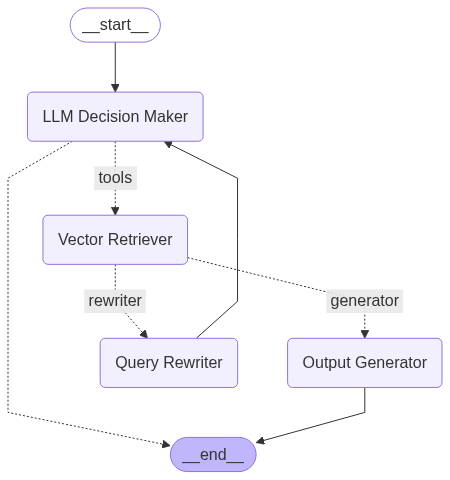

In [ ]:
# %%
from IPython.display import Image, display

# 🖼️ Render the compiled LangGraph app as a PNG using Mermaid
display(Image(app.get_graph().draw_mermaid_png()))


In [24]:
# Run test queries through the compiled app
app.invoke({"messages": ["what is LLM Powered Autonomous Agents? explain planning, reflection, and prompt engineering using LangChain."]})
app.invoke({"messages": ["hi, how are you GPT?"]})
app.invoke({"messages": ["what is the capital of India?"]})

# Another complex query for evaluation
question = "Can you explain what task decomposition is and why Chain of Thought (CoT; Wei et al. 2022) has become a standard prompting technique for complex tasks?"
app.invoke({"messages": [question]})


---- CALL: LLM_DECISION_MAKER ----
---- CALL: GRADE DOCUMENTS ----
---- DECISION: Relevant ----
---- CALL: GENERATE ANSWER ----
Generated response: content='LLM Powered Autonomous Agents use planning and reflection to improve reasoning in language models. The LangChain approach in prompt engineering enhances steerability by active prompting with the chain of thought for large language models. The LangChain method integrates planning, reflection, and engineering aspects to optimize the performance of LLMs in various tasks.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 324, 'total_tokens': 387, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BmjzB1eWMvc5gpbhzBuIWlEQJXIf0', 'service_tier'

{'messages': [HumanMessage(content='Can you explain what task decomposition is and why Chain of Thought (CoT; Wei et al. 2022) has become a standard prompting technique for complex tasks?', additional_kwargs={}, response_metadata={}, id='7925e33c-69f6-4772-aa7f-af2ccf6aaa1f'),
  AIMessage(content="Task decomposition refers to breaking down a complex task into smaller, more manageable sub-tasks. This approach allows for easier problem-solving by tackling one component at a time, leading to a more systematic and efficient completion of the overall objective. \n\nChain of Thought (CoT), proposed by Wei et al. in 2022, has emerged as a standard prompting technique for complex tasks due to its effectiveness in guiding models through a sequence of coherent steps. CoT utilizes a chaining mechanism where tasks are broken down into interrelated sub-tasks, forming a logical chain of prompts. This chaining process facilitates the completion of a complex task by providing context and direction at 

1. take multiple data sources and complex data sources
2. strict your prompting in every node based on your desired output
3. check question and generated docuemnt(k=keep more than 5 with strict prompting according to your usecase)

what is a main aim of this agentic rag?
answer: to provide more security and more validation and more determenstic flow to the RAG

## As a homework now try it out this one: Corrective RAG(Type of the Agentic RAG)

in this architecutre you are correcting the infomation from any other data source if retriever is not able to generate a correct output(in this architecture the external data source is web search)

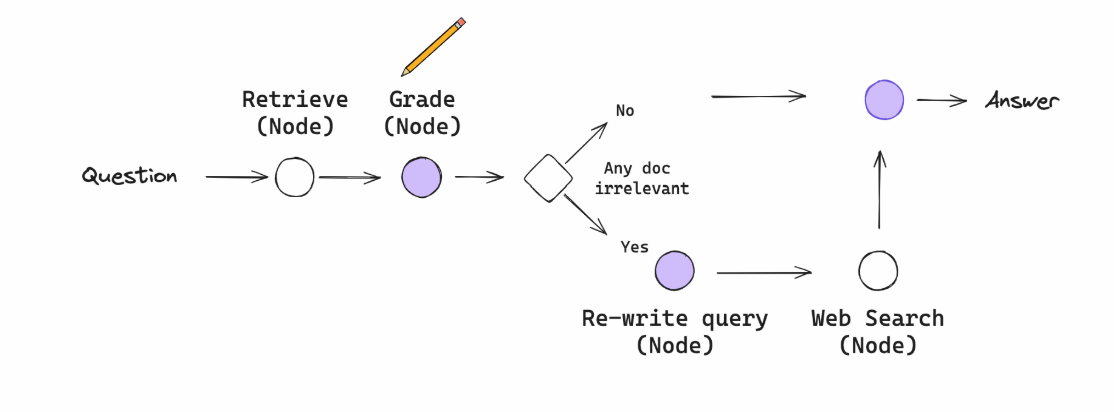